#Imports and Download custom dataset
1. Dataset download from this [this](https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip)
2. Basic Imports 

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import tensorflow as tf
from numpy.random import randint
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from google.colab.patches import cv2_imshow
from sklearn.metrics import accuracy_score
%matplotlib inline
!wget https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip
!unzip /content/trainPart1.zip

On why I chose this preprocessing steps
- On viewing the dataset it was seen that it a lot of margin around it and the image in qustion was not in focus, so it was recentred using bounder funciotn
- Secondly images are of very high quality 900 pixels x 1080 so it was resized to a smaller size of 64x64
- Also since the thickness was very thick for letters, a gaussian blue was applied
- All these have been discussed in error logs in detail

#Preprocessing
- ```bounder```: This function extracts the region of interest around the digit/character, since the characters do not fill the entire image
- In the next code block we iterate over the directories and for the supervised examples X and Y. 
- The following preprocessing has been applied to the image
  1. Image is converted to grayscale
  2. pixels are inverted thorugh ``cv2_bitwise``
  3. Images are resized to uniform shape of ``input_shape=(64,64)``
  4. Edges are smoothened using Gaussian Blur
  5. Label vector of dimension ``classes=62`` is formed.

In [ ]:
input_shape=(64,64,1)
classes=62
par_dir="/content/train"
dicti={}

In [ ]:
def bounder(thresh,margin=12):     #thresh is the image input
  sh=thresh.shape
  x_min,x_max,y_min,y_max=10000,-10000,10000,-10000
  for x in range(sh[0]):
    if np.amax(thresh[x])!=0: x_min,x_max=min(x_min,x),max(x_max,x)
  for y in range(sh[1]):
    if np.amax(thresh.T[y])!=0: y_min,y_max=min(y_min,y),max(y_max,y)
  return thresh[max(x_min-margin,0):min(x_max+margin,sh[1]),max(y_min-margin,0):min(y_max+margin,sh[1])]

In [ ]:
X,Y = [],[]
for foldername in os.listdir(par_dir):
  for filename in os.listdir(par_dir+"/"+str(foldername)):
    filepath=par_dir+"/"+str(foldername)+"/"+str(filename)
    image=cv2.imread(filepath)
    thresh = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.bitwise_not(thresh)    #invert pixels, black background and white characters
    thresh=cv2.GaussianBlur(cv2.resize(bounder(thresh),(64,64)), (3, 3), 0)
    X.append(thresh)
    vec=np.zeros(classes)
    dicti[int(foldername[-2:])-1]=thresh
    vec[int(foldername[-2:])-1]=1
    Y.append(vec) 
X=np.expand_dims(np.array(X),3)
Y=np.array(Y)

###Display sample preprocesed images with their corresponding label
- The one hot vector has the corresponding index as 1

- I always view sample images before doing proceeding with model, it gives some idea about the dataset

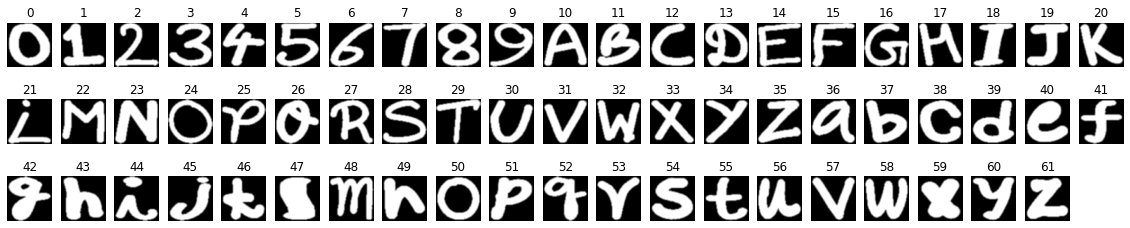

In [ ]:
plt.figure(figsize=(20,4))
for i,k in enumerate(sorted(dicti.keys())):
  plt.subplot(3,21,i+1)
  plt.axis('off')
  plt.imshow(np.squeeze(dicti[k]),'gray')
  plt.title(str(k))

#Training

### Train test split
1. A 70-30 split is performed in the dataset
2. We define a keras data augmenter, ```ImageDataGenerator``` which will augment images on the fly. We resort to only rotating the images since some images are rotated in dataset are not exactly vertical

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.30)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)
datagen = tf.keras.preprocessing.image.ImageDataGenerator( 
        rotation_range=30,
        horizontal_flip=False)
datagen.fit(X_train)

(1736, 64, 64, 1) (1736, 62) (744, 64, 64, 1) (744, 62)


### Model: CustomCNN
0. First I started with a very simple LeNet architecture which gives acceptable accuracy on MNIST dataset. It has been discussed in errorlogs
1. Since the dataset is not very complex and similar to MNIST dataset, the model architecture is a modified LeNet simlar to this [architecture](https://towardsdatascience.com/going-beyond-99-mnist-handwritten-digits-recognition-cfff96337392), with the following modifications.
  - Initial layers contain repeated units containing, 2 Cov layers followed by BatchNorm and relu activation and Maxpooling.
  - For regularization dropout layers have been added, since by dropping neurons randomly makes model more robust and generalize better.
3. For training a learning rate decay has been added, reducing on the basis of validation loss

4. Since when approcahing the minima for loss function the curve becomes less and less concave, reducing the learning rate is often useful to reach the optimum weight values. explaine [here](https://arxiv.org/abs/1908.01878)
5. ReduceOnPlateau reduces the learning rate when the loss on validation stagnates
6. ReLu function has been very successfull in modern Neural Netowrks so I have stuck with it.
7. Last layer uses softmax which not only gives probability of classes but normalized so that sum across a 62 is 1. This is done assuming that all input images are of exatly one class.
8. This is closed world problem [explained here](https://www.cs.uic.edu/~liub/open-classification.html)
9. Adam optimizer has been used, since it is quite popular these days in machine learning, owing to its sucess on so many other models and dataset and secondly its quite useful on large datasets and coupled with variable learning rate.
10. A batch size of 32 was chosen, since smaller batch size often has a regularizing effect, and it's quite essential to this model since there is slight overfit 
11. Image data augmentation also helps to compensate for smaller dataset size

In [ ]:
def CustomCNN_arch(input_shape = (64, 64, 1), classes = 10):
    model = tf.keras.Sequential([
    Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = input_shape),
    Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),  
    BatchNormalization(), Activation("relu"), MaxPooling2D(pool_size = 2, strides = 2), Dropout(0.25), 
    Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu'),
    Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
    BatchNormalization(), Activation("relu"), MaxPooling2D(pool_size = 2, strides = 2), Dropout(0.25),
    Flatten(name = 'flatten'),
    Dense(units = 256), BatchNormalization(), Activation("relu"),  
    Dense(units = 128), BatchNormalization(), Activation("relu"),
    Dropout(0.25),
    Dense(units = classes, activation = 'softmax')])
    return model
checkpoint_filepath = '/content/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,
                                                               monitor='val_accuracy', mode='max', save_best_only=True)
model = CustomCNN_arch(input_shape = input_shape, classes = classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 7)
model.fit(datagen.flow(X_train, Y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32, epochs=100,callbacks = [variable_learning_rate,model_checkpoint_callback], validation_data = (X_test,Y_test)) 

Epoch 1/100
54/54 [==============================] - 2s 25ms/step - loss: 3.8337 - accuracy: 0.1110 - val_loss: 3.4101 - val_accuracy: 0.1801
Epoch 2/100
54/54 [==============================] - 1s 21ms/step - loss: 2.3560 - accuracy: 0.4430 - val_loss: 2.6677 - val_accuracy: 0.3024
Epoch 3/100
54/54 [==============================] - 1s 21ms/step - loss: 1.8151 - accuracy: 0.5701 - val_loss: 1.5672 - val_accuracy: 0.5578
Epoch 4/100
54/54 [==============================] - 1s 21ms/step - loss: 1.3888 - accuracy: 0.6475 - val_loss: 1.2939 - val_accuracy: 0.6438
Epoch 5/100
54/54 [==============================] - 1s 21ms/step - loss: 1.1619 - accuracy: 0.7099 - val_loss: 0.8895 - val_accuracy: 0.7527
Epoch 6/100
54/54 [==============================] - 1s 21ms/step - loss: 0.9864 - accuracy: 0.7523 - val_loss: 0.9591 - val_accuracy: 0.7151
Epoch 7/100
54/54 [==============================] - 1s 21ms/step - loss: 0.8684 - accuracy: 0.7602 - val_loss: 0.9007 - val_accuracy: 0.7325
Epoch 

In [ ]:
#loading best weights and evaluating
!wget https://github.com/mh2029/Midas_Task2/blob/main/Weights/Important_weights/point1_customcnn.hdf5?raw=true
model=CustomCNN_arch(input_shape,classes)
model.load_weights( '/content/point1_customcnn.hdf5?raw=true')
def accuracy(x_t,y_t):
  predict=np.argmax(model.predict(x_t),1)
  act=np.argmax(y_t,-1)
  return accuracy_score(predict,act)
print('Peformance on Validation set: {}'.format(accuracy(X_test,Y_test)))
print('Peformance on Train set: {}'.format(accuracy(X_train,Y_train)))

Peformance on Validation set: 0.8400537634408602
Peformance on Train set: 0.978110599078341


## Infering Predictions

In [ ]:
j=0
wrong=[]
for i in range(X_test.shape[0]):
  img=X_test[i]
  predict=np.argmax(ModifiedLenet.predict(np.expand_dims(img,0)),1)[0]
  act=np.argmax(Y_test[i],-1)
  if predict!=act:
    wrong.append((act,predict))
    j+=1
wrong.sort()
for i in wrong:
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(dicti[i[0]])
  plt.title('actual: '+str(i[0]))
  plt.subplot(1,2,2)
  plt.imshow(dicti[i[1]])
  plt.title('Predicted: '+str(i[1]))
  #   # np.argmax(ModifiedLenet.predict(X_test),-1)-np.argmax(Y_test,-1)

#Model: Resnet50v2: Similar training as above, just different architecture, no pretrained weights used.

* Since ResNet50v2 is an already tested architecture on various dataset it makes sense to give it a try instead of building a custom CNN.

* This architecture has so called residual layers, where there is a shortcut connection between different layers hence learning from some initial layer my be transferred directly to some further layer.
* Please refer [this paper](https://arxiv.org/abs/1603.05027) for more information.

In [ ]:
def resnetv2(input_shape,classes):
  mobile = tf.keras.applications.ResNet50V2(include_top=True,weights=None,input_tensor=None,input_shape=input_shape,pooling=None,classes=classes)
  return mobile
def printmodel(model):
  curr_model = model
  curr_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint_filepath = '/content/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
  variable_learning_rate = ReduceLROnPlateau(monitor='val_loss', factor = 0.2, patience = 2)
  history = curr_model.fit(datagen.flow(X_train, Y_train, batch_size=32), epochs = 50, batch_size = 32, 
                           callbacks = [variable_learning_rate,model_checkpoint_callback], validation_data = (X_test,Y_test))
  return model
model1=printmodel(resnetv2(input_shape,classes))

Epoch 1/50
55/55 [==============================] - 9s 81ms/step - loss: 3.8719 - accuracy: 0.1254 - val_loss: 15.9668 - val_accuracy: 0.0121
Epoch 2/50
55/55 [==============================] - 4s 65ms/step - loss: 1.5572 - accuracy: 0.5102 - val_loss: 14.4071 - val_accuracy: 0.0887
Epoch 3/50
55/55 [==============================] - 4s 65ms/step - loss: 1.1525 - accuracy: 0.6564 - val_loss: 3.8103 - val_accuracy: 0.4126
Epoch 4/50
55/55 [==============================] - 4s 66ms/step - loss: 0.9224 - accuracy: 0.7330 - val_loss: 5.0240 - val_accuracy: 0.3723
Epoch 5/50
55/55 [==============================] - 4s 65ms/step - loss: 0.7087 - accuracy: 0.7586 - val_loss: 2.2233 - val_accuracy: 0.5645
Epoch 6/50
55/55 [==============================] - 4s 66ms/step - loss: 0.7720 - accuracy: 0.7668 - val_loss: 2.5897 - val_accuracy: 0.5497
Epoch 7/50
55/55 [==============================] - 4s 66ms/step - loss: 0.5920 - accuracy: 0.8119 - val_loss: 1.7707 - val_accuracy: 0.6505
Epoch 8/50


In [ ]:
# model1=printmodel(resnetv2(input_shape,classes)) #uncomment if you want to train the network
!wget https://github.com/mh2029/Midas_Task2/blob/main/Weights/Important_weights/point1_88_Resnetv2_.hdf5?raw=true
model1=resnetv2(input_shape,classes)
model1.load_weights( '/content/point1_88_Resnetv2_.hdf5?raw=true')
def accuracy(x_t,y_t):
  predict=np.argmax(model1.predict(x_t),1)
  act=np.argmax(y_t,-1)
  return accuracy_score(predict,act)
print('Peformance on Validation set: {}'.format(accuracy(X_test,Y_test)))
print('Peformance on Train set: {}'.format(accuracy(X_train,Y_train)))

Peformance on Validation set: 0.8561827956989247
Peformance on Train set: 0.9625576036866359


#More ideas to imporve the accuracy

The main reason for accuracy below 90% is that the dataset size is quite small only 40 images per class. So we can use a Convolutional VAE(Variational autoencoder) which will learn the probability distribution of images and can be used to expand the dataset size. 

#Evaluating where the model is going wrong
It can be seen that there is less precision on some small and capitalk letters like 'o' and 'O' and '0', 's' and 'S' etc. and they are also indistinguidhable by humans. So merging these classes will lead to better recognition.

In [ ]:
y_true,y_pred=Y_test,np.argmax(model1.predict(X_test),1)
sklearn.metrics.classification_report(y_true, y_pred) 

To test the model on a new test set, follow the following procedure
1. Load the individual images in a list and thier corresponding labels
2. Preprocess rach image as done: 

`` image=cv2.imread(filepath)``

``thresh = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)``

   `` thresh = cv2.bitwise_not(thresh)``

  ``  thresh=cv2.GaussianBlur(cv2.resize(bounder(thresh),(64,64)), (3, 3), 0)``
    
3. create the model architecture(Resnet or custom CNN) and load it's weight, they have been stored in weights folder.
4. Test it using the fucntion accuracy